# Business Problem:
# Exploring the distribution of microfinance loans across different countries and sectors. Specifically, the problem you're addressing seems to be identifying which countries and sectors have the highest demand for microfinance loans and how factors like loan terms, loan sizes, and repayment intervals vary across different sectors and countries.

# Reseach question:
# "Which countries and sectors exhibit the highest loan demand, and how do loan terms, loan sizes, and repayment intervals vary across these categories?"

In [135]:
import requests
import zipfile
import io
import pandas as pd

# URLs
kiva_loans_part_0_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_0.csv.zip'
kiva_loans_part_1_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_1.csv.zip'
kiva_loans_part_2_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/kiva_loans_part_2.csv.zip'
mpi_region_locations_url = 'https://raw.githubusercontent.com/aaubs/ds-master/main/data/assignments_datasets/KIVA/kiva_mpi_region_locations.csv'
loan_theme_ids_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/loan_theme_ids.csv.zip'
loan_themes_by_region_url = 'https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/KIVA/loan_themes_by_region.csv'

# Function to download and extract CSV from a ZIP file
def download_and_load_csv_from_zip(url):
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as z:
        for file_name in z.namelist():
            if not file_name.startswith('__MACOSX') and file_name.endswith('.csv'):
                with z.open(file_name) as f:
                    return pd.read_csv(f)

# Load the required CSV files
kiva_loans_part_0_df = download_and_load_csv_from_zip(kiva_loans_part_0_url)
kiva_loans_part_1_df = download_and_load_csv_from_zip(kiva_loans_part_1_url)
kiva_loans_part_2_df = download_and_load_csv_from_zip(kiva_loans_part_2_url)
mpi_region_locations_df = pd.read_csv(mpi_region_locations_url)
loan_theme_ids_df = download_and_load_csv_from_zip(loan_theme_ids_url)
loan_themes_by_region_df = pd.read_csv(loan_themes_by_region_url)

# Combine all Kiva loans data into one dataframe
kiva_loans_combined_df = pd.concat([kiva_loans_part_0_df, kiva_loans_part_1_df, kiva_loans_part_2_df], ignore_index=True)

# remove duplicate rows based on 'id'
kiva_loans_combined_df = kiva_loans_combined_df.drop_duplicates(subset='id')

merged_dataset = kiva_loans_combined_df.merge(loan_theme_ids_df, how='left', on='id')
merged_dataset2 = merged_dataset.merge(loan_themes_by_region_df, how='left', on=['Partner ID', 'Loan Theme ID', 'country', 'region'])

In [150]:
# Drop unnecessary columns
df_cleaned = merged_dataset2.drop(columns=[
    'country_code', 'date', 'currency', 'partner_id', 'tags',
    'Loan Theme ID', 'Partner ID', 'forkiva', 'geocode_old', 'ISO',
    'LocationName', 'mpi_region', 'mpi_geo'
])

# Check for missing values
missing_values = df_cleaned.isnull().sum()

# Handling 'use' column: remove rows where 'use' is missing
df_cleaned = df_cleaned.dropna(subset=['use'])

# Handling 'region' column: fill with 'Unknown'
df_cleaned['region'] = df_cleaned['region'].fillna('Unknown')

# Handling 'disbursed_time' and 'funded_time':filling with a placeholder if missing
df_cleaned['disbursed_time'] = df_cleaned['disbursed_time'].fillna('Not provided')
df_cleaned['funded_time'] = df_cleaned['funded_time'].fillna('Not provided')

# Handling 'borrower_genders':filling with 'unknown'
df_cleaned['borrower_genders'] = df_cleaned['borrower_genders'].fillna('unknown')

# Drop rows where critical columns are missing
df_cleaned = df_cleaned.dropna(subset=['Loan Theme Type_x', 'Field Partner Name', 'sector_y', 'Loan Theme Type_y', 'amount'])

# Convert 'borrower_genders' to proper columns for male and female count
def count_gender(genders, gender_to_count):
    if pd.isna(genders):
        return 0
    return sum([1 for gender in genders.split(', ') if gender.strip() == gender_to_count])

df_cleaned['no_male_borrower'] = df_cleaned['borrower_genders'].apply(lambda x: count_gender(x, 'male'))
df_cleaned['no_female_borrower'] = df_cleaned['borrower_genders'].apply(lambda x: count_gender(x, 'female'))

# Create a new column indicating if the borrower is single or part of a group
df_cleaned['borrower_type'] = df_cleaned.apply(lambda row: 'single' if (row['no_male_borrower'] + row['no_female_borrower']) == 1 else 'group', axis=1)

# Drop the original 'borrower_genders' column
df_cleaned = df_cleaned.drop(columns=['borrower_genders'])

# Lowercase and remove whitespace from categorical columns
df_cleaned[['activity', 'sector_x', 'use', 'country', 'region', 'repayment_interval',
            'Loan Theme Type_x', 'Field Partner Name', 'sector_y', 'Loan Theme Type_y']] = df_cleaned[
    ['activity', 'sector_x', 'use', 'country', 'region', 'repayment_interval',
     'Loan Theme Type_x', 'Field Partner Name', 'sector_y', 'Loan Theme Type_y']].apply(lambda x: x.str.lower().str.strip())

# Display the cleaned dataset
print(df_cleaned.head())


       id  funded_amount  loan_amount       activity        sector_x  \
1  653053          575.0        575.0       rickshaw  transportation   
3  653063          200.0        200.0     embroidery            arts   
4  653084          400.0        400.0     milk sales            food   
7  653078          400.0        400.0   beauty salon        services   
8  653082          475.0        475.0  manufacturing   manufacturing   

                                                 use   country        region  \
1  to repair and maintain the auto rickshaw used ...  pakistan        lahore   
3  to purchase an embroidery machine and a variet...  pakistan        lahore   
4                           to purchase one buffalo.  pakistan  abdul hakeem   
7           to buy more hair and skin care products.  pakistan     ellahabad   
8  to purchase leather, plastic soles and heels i...  pakistan        lahore   

                 posted_time             disbursed_time  ...     amount  \
1  2014-01-

<ipython-input-152-a1a7c54002a1>:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='loan_count', y='country', data=loan_count_by_country, palette='Blues_d')


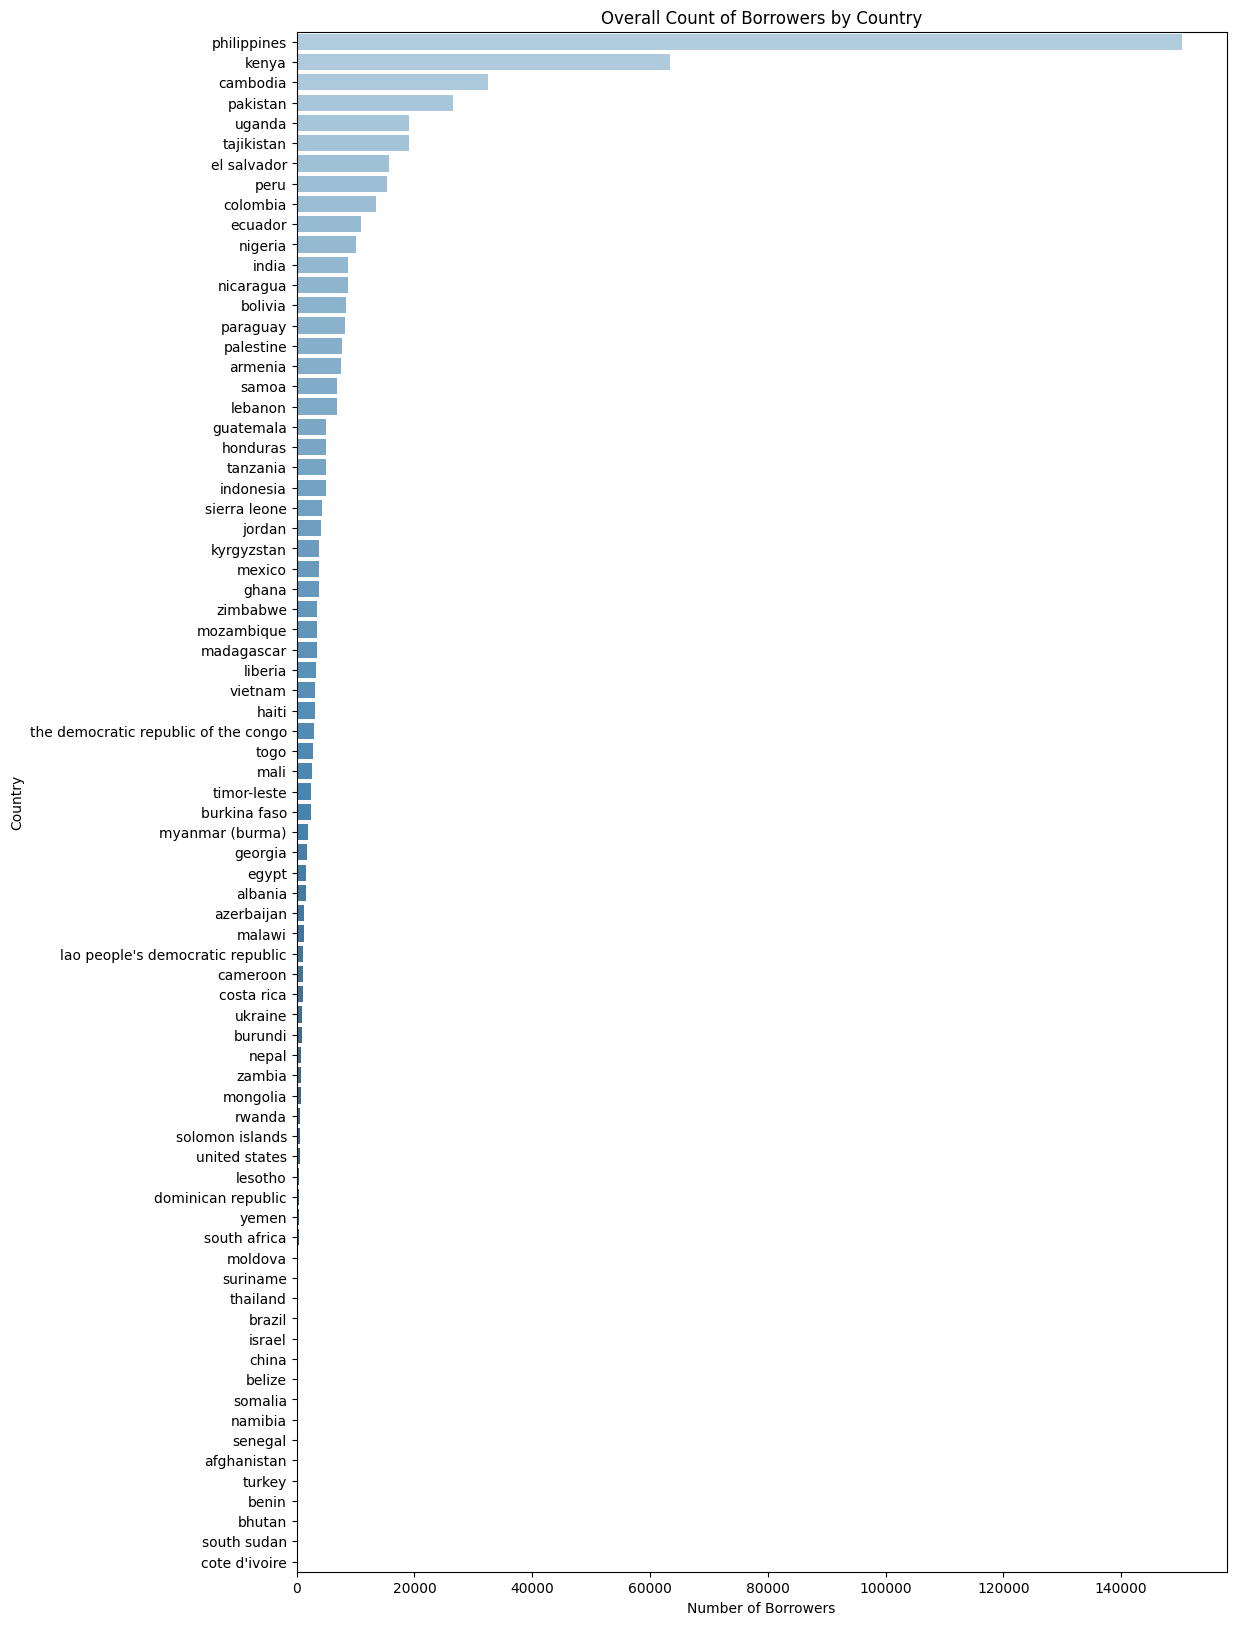

In [152]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group the data by country and count the number of loans (borrowers) for each country
loan_count_by_country = df_cleaned.groupby('country')['id'].count().reset_index().sort_values(by='id', ascending=False)

# Rename columns for clarity
loan_count_by_country.columns = ['country', 'loan_count']

# Plotting the overall count of borrowers by country
plt.figure(figsize=(12, 20))
sns.barplot(x='loan_count', y='country', data=loan_count_by_country, palette='Blues_d')
plt.xlabel('Number of Borrowers')
plt.ylabel('Country')
plt.title('Overall Count of Borrowers by Country')
plt.show()


The Philippines, Kenya, and Cambodia lead in terms of the total number of borrowers, indicating high demand for loans in these countries.
This high volume can be reflective of both the size of the population in need and the effectiveness of microfinance services in these regions.

<ipython-input-153-15dbd88f048e>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='unique_regions', y='country', data=unique_regions_by_country, palette='coolwarm')


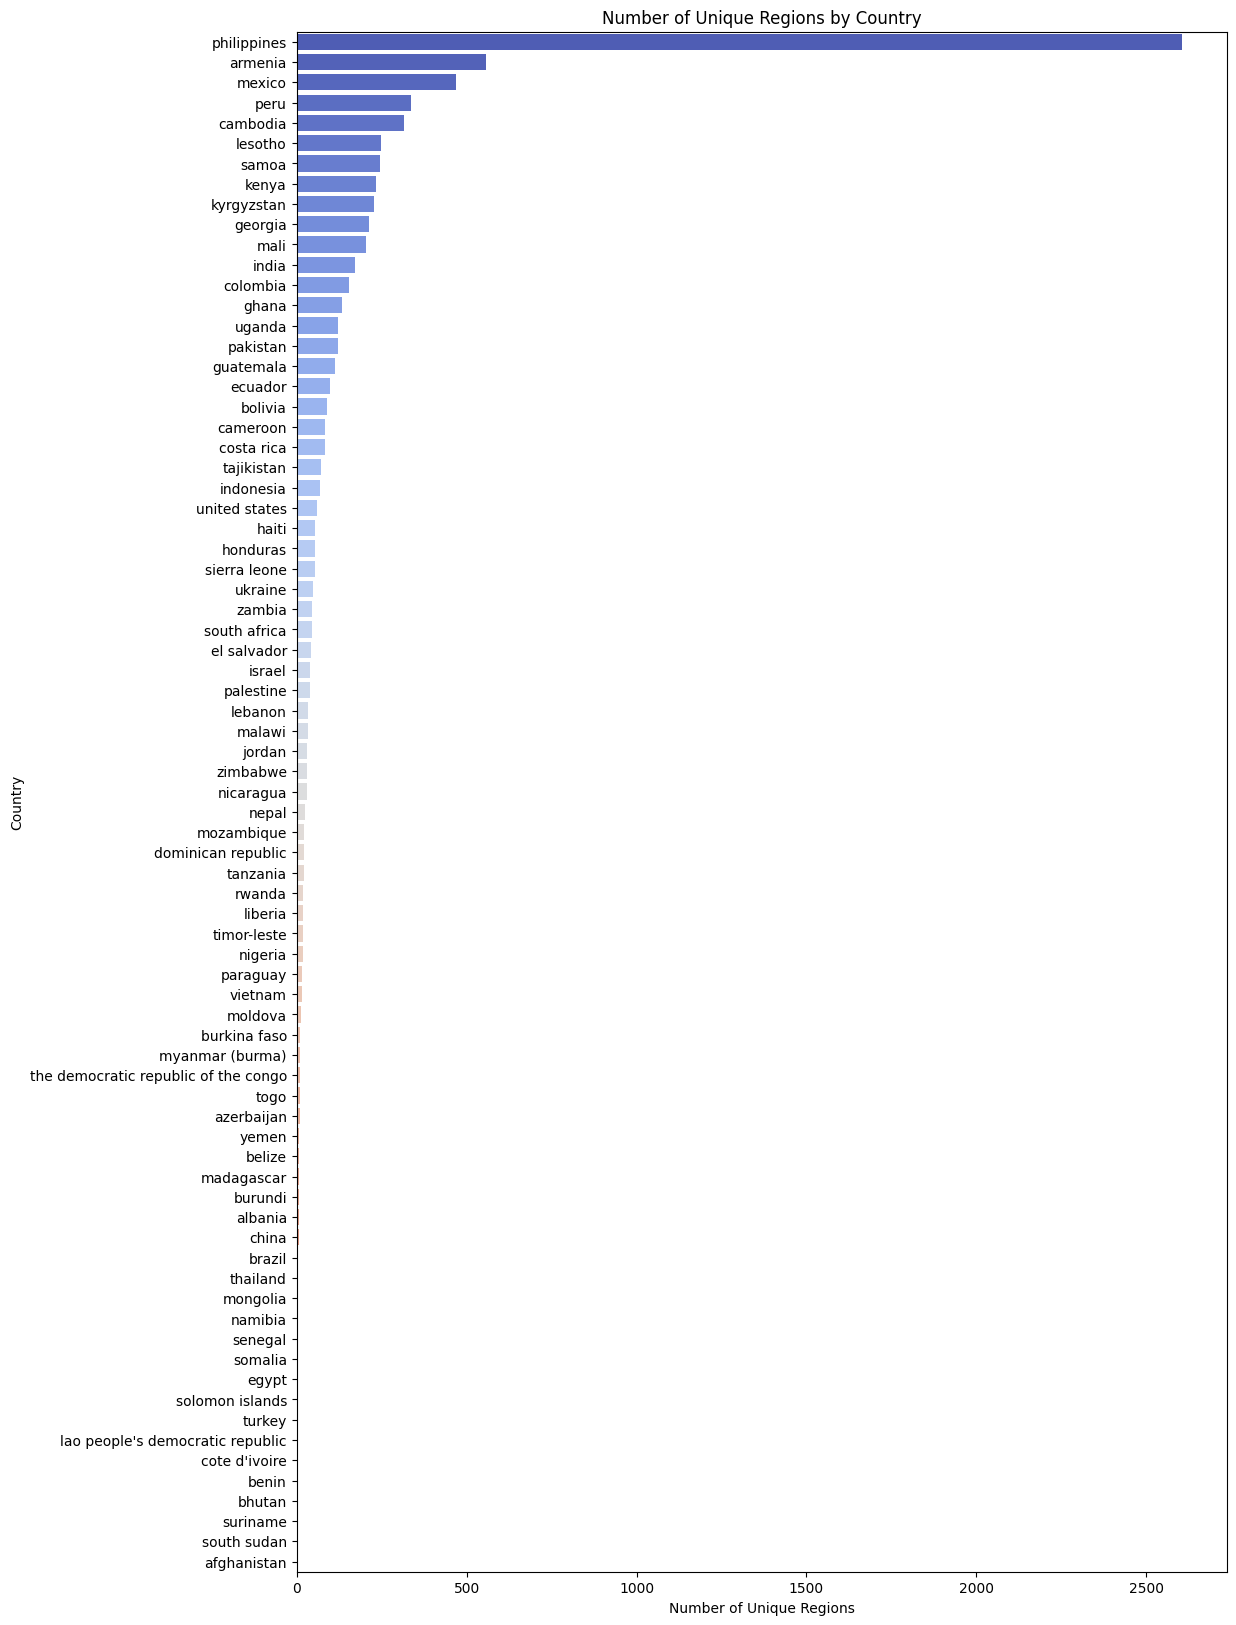

In [153]:
# Group the data by country and count the number of unique regions for each country
unique_regions_by_country = df_cleaned.groupby('country')['region'].nunique().reset_index().sort_values(by='region', ascending=False)

# Rename columns for clarity
unique_regions_by_country.columns = ['country', 'unique_regions']

# Plotting the number of unique regions for each country
plt.figure(figsize=(12, 20))
sns.barplot(x='unique_regions', y='country', data=unique_regions_by_country, palette='coolwarm')
plt.xlabel('Number of Unique Regions')
plt.ylabel('Country')
plt.title('Number of Unique Regions by Country')
plt.show()


The Philippines also tops the list in terms of the number of unique regions receiving loans, suggesting a widespread microfinance network that penetrates deeply into the country.

<ipython-input-171-9cf46850b3fb>:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='loan_count', y='sector', data=sector_loan_counts, palette='Blues_d')


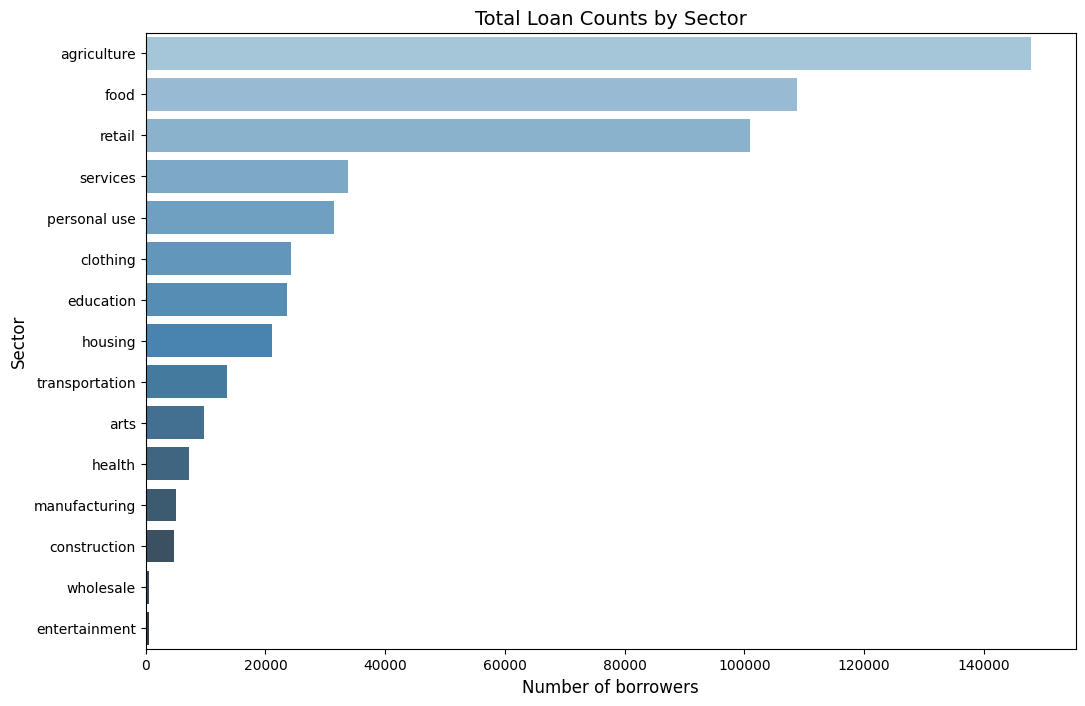

In [171]:
# Grouping the data by sector and calculating the count of loans for each sector
sector_loan_counts = df_cleaned.groupby('sector_x')['id'].count().reset_index().sort_values(by='id', ascending=False)

# Renaming columns for better understanding
sector_loan_counts.columns = ['sector', 'loan_count']

# Plotting the distribution of loan counts by sector
plt.figure(figsize=(12, 8))
sns.barplot(x='loan_count', y='sector', data=sector_loan_counts, palette='Blues_d')
plt.xlabel('Number of borrowers', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.title('Total Loan Counts by Sector', fontsize=14)
plt.show()


Agriculture and Food are the sectors with the highest number of loans, which may indicate the primary economic activities in the regions studied.

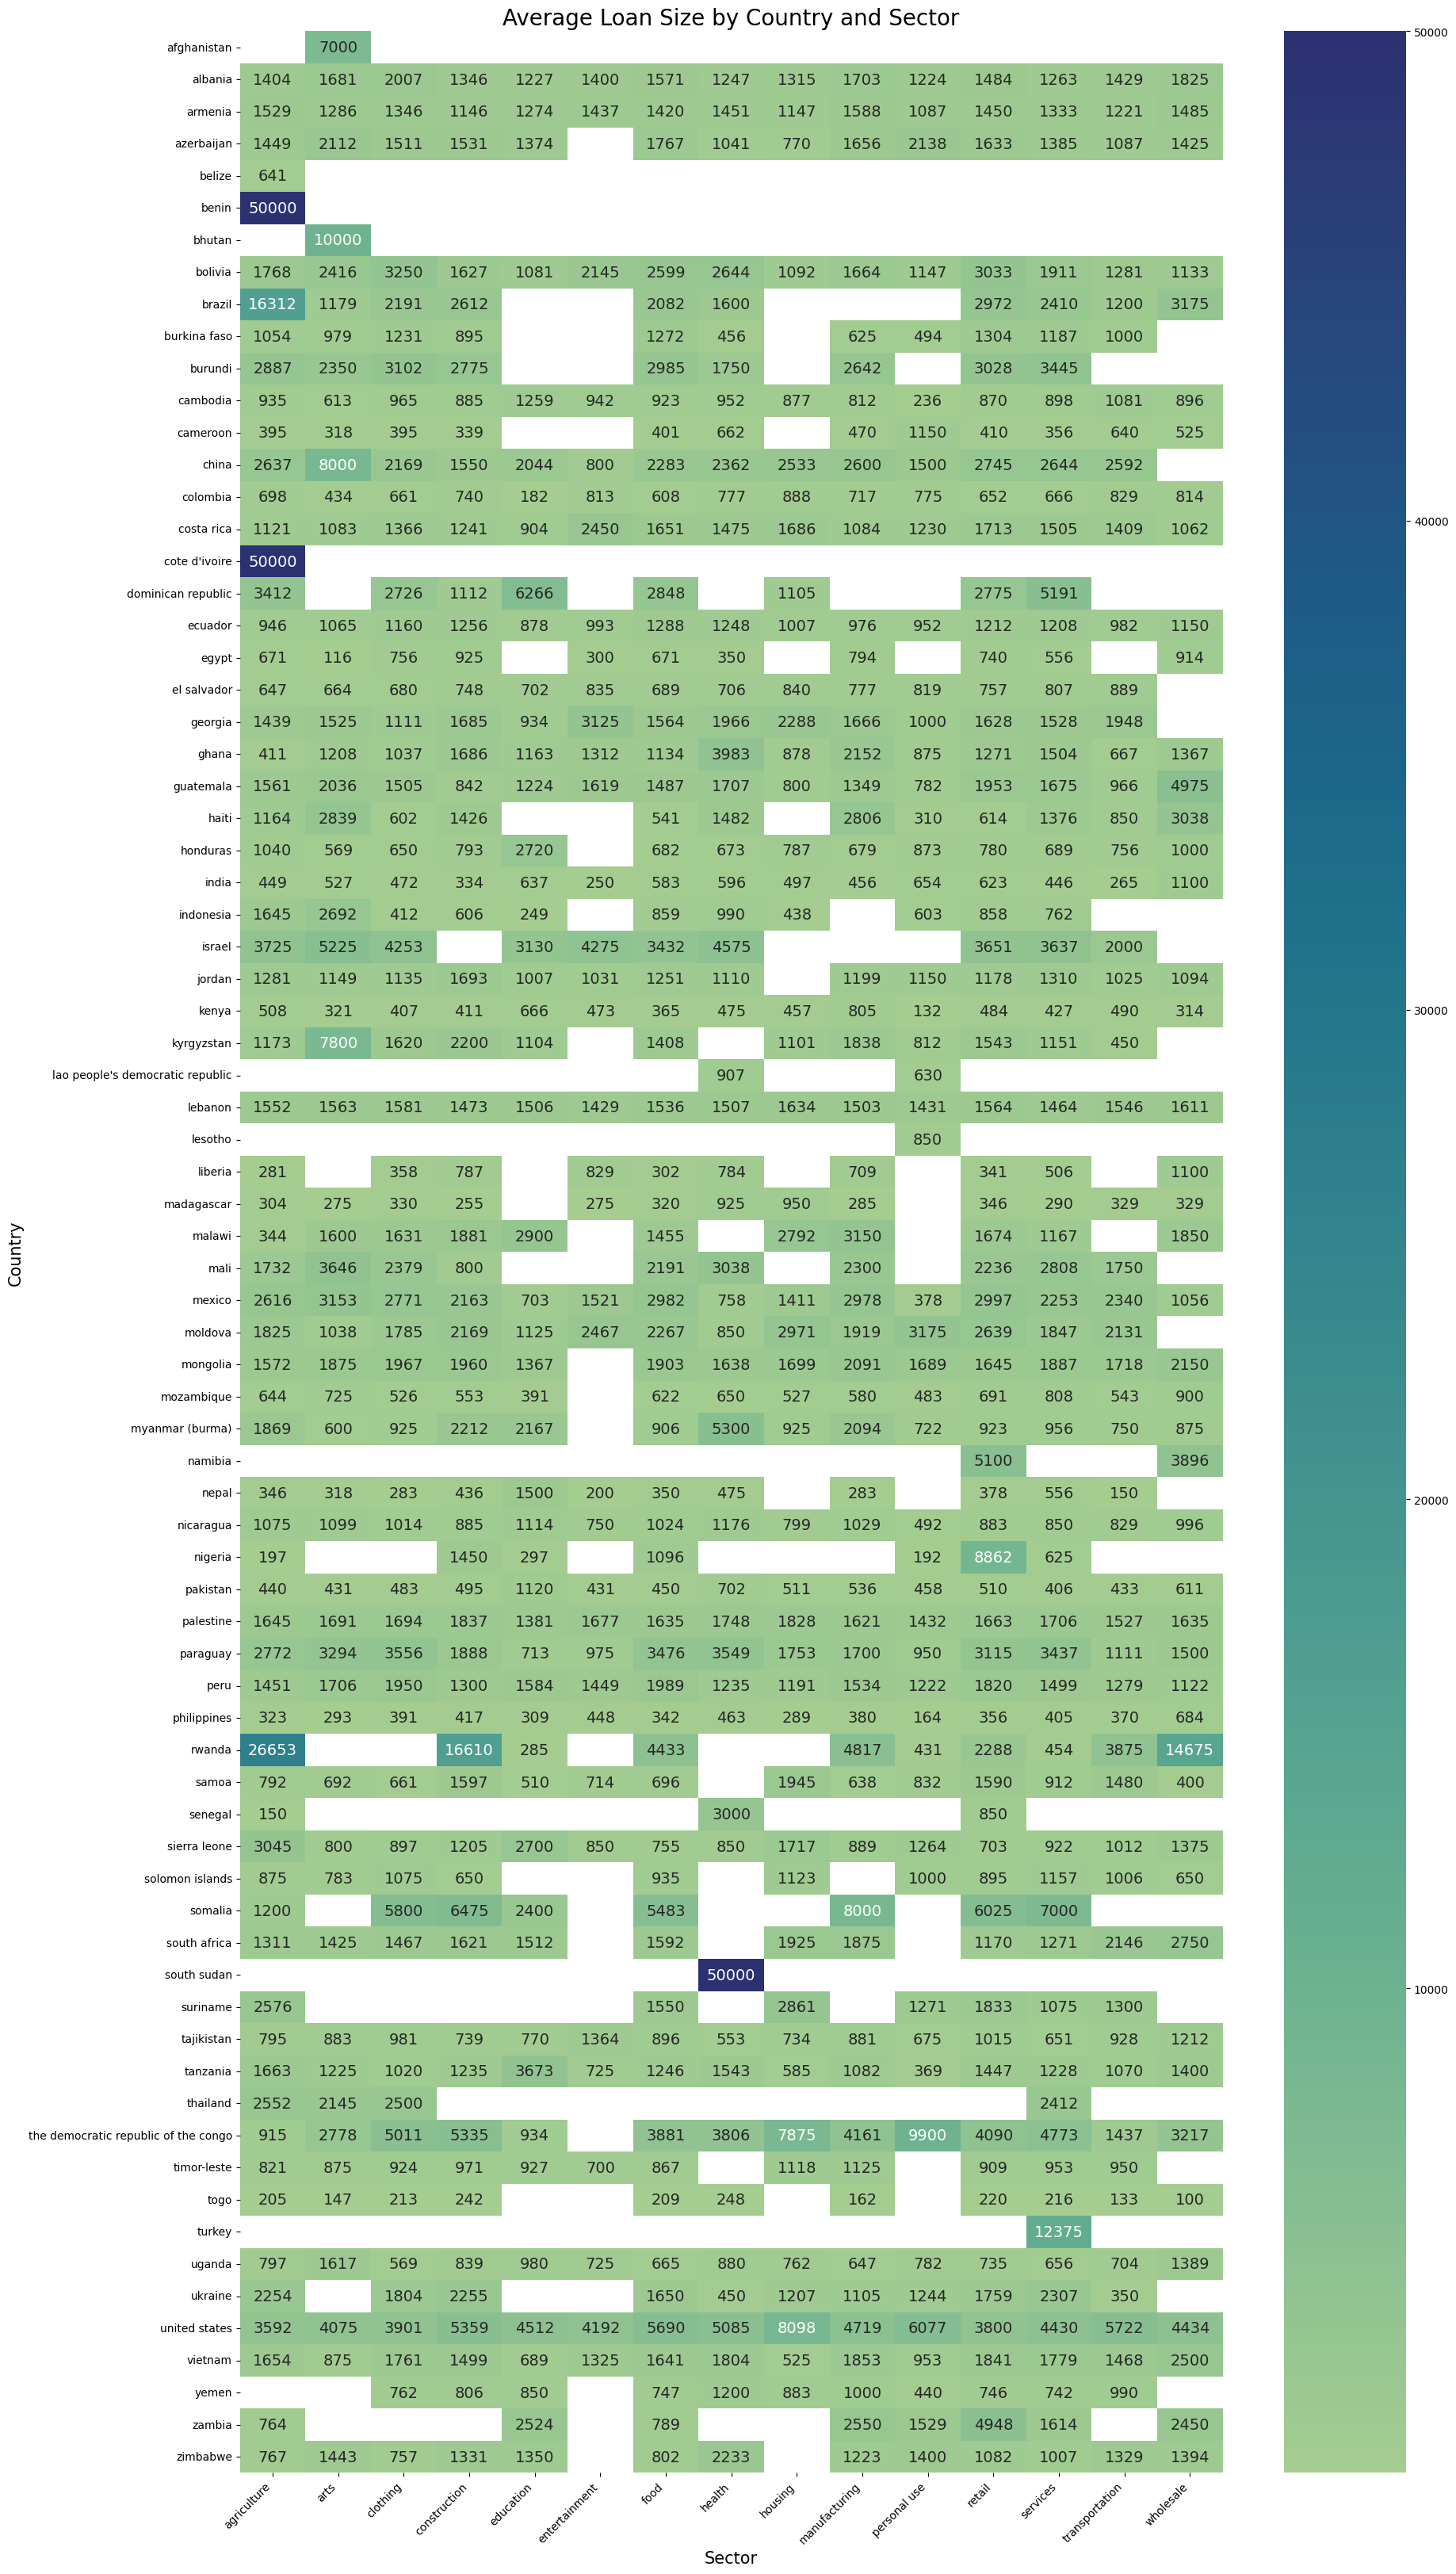

In [187]:
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate average loan size by country and sector
avg_loan_size = df_cleaned.groupby(['country', 'sector_x'])['loan_amount'].mean().reset_index()

# Create a pivot table for the heatmap
heatmap_data = avg_loan_size.pivot_table(index='country', columns='sector_x', values='loan_amount')

# Plotting the heatmap
plt.figure(figsize=(20, 40))
ax = sns.heatmap(heatmap_data, annot=True, fmt=".0f", cmap="crest", annot_kws={"size": 14})
plt.title('Average Loan Size by Country and Sector', fontsize=20)
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.yticks(rotation=0, fontsize=10)
plt.xlabel('Sector', fontsize=15)
plt.ylabel('Country', fontsize=15)
plt.show()



There is considerable variation in average loan sizes across different sectors and countries, suggesting differential capital needs and varying levels of economic development.

Countries like Belize and Bhutan show unusually high average loan sizes across several sectors, which might reflect higher costs of living, larger scale of projects, or less dense populations receiving more substantial individual loans.

Conversely, countries with smaller average loan sizes may be focusing on micro-loans accessible to a broader segment of the population.

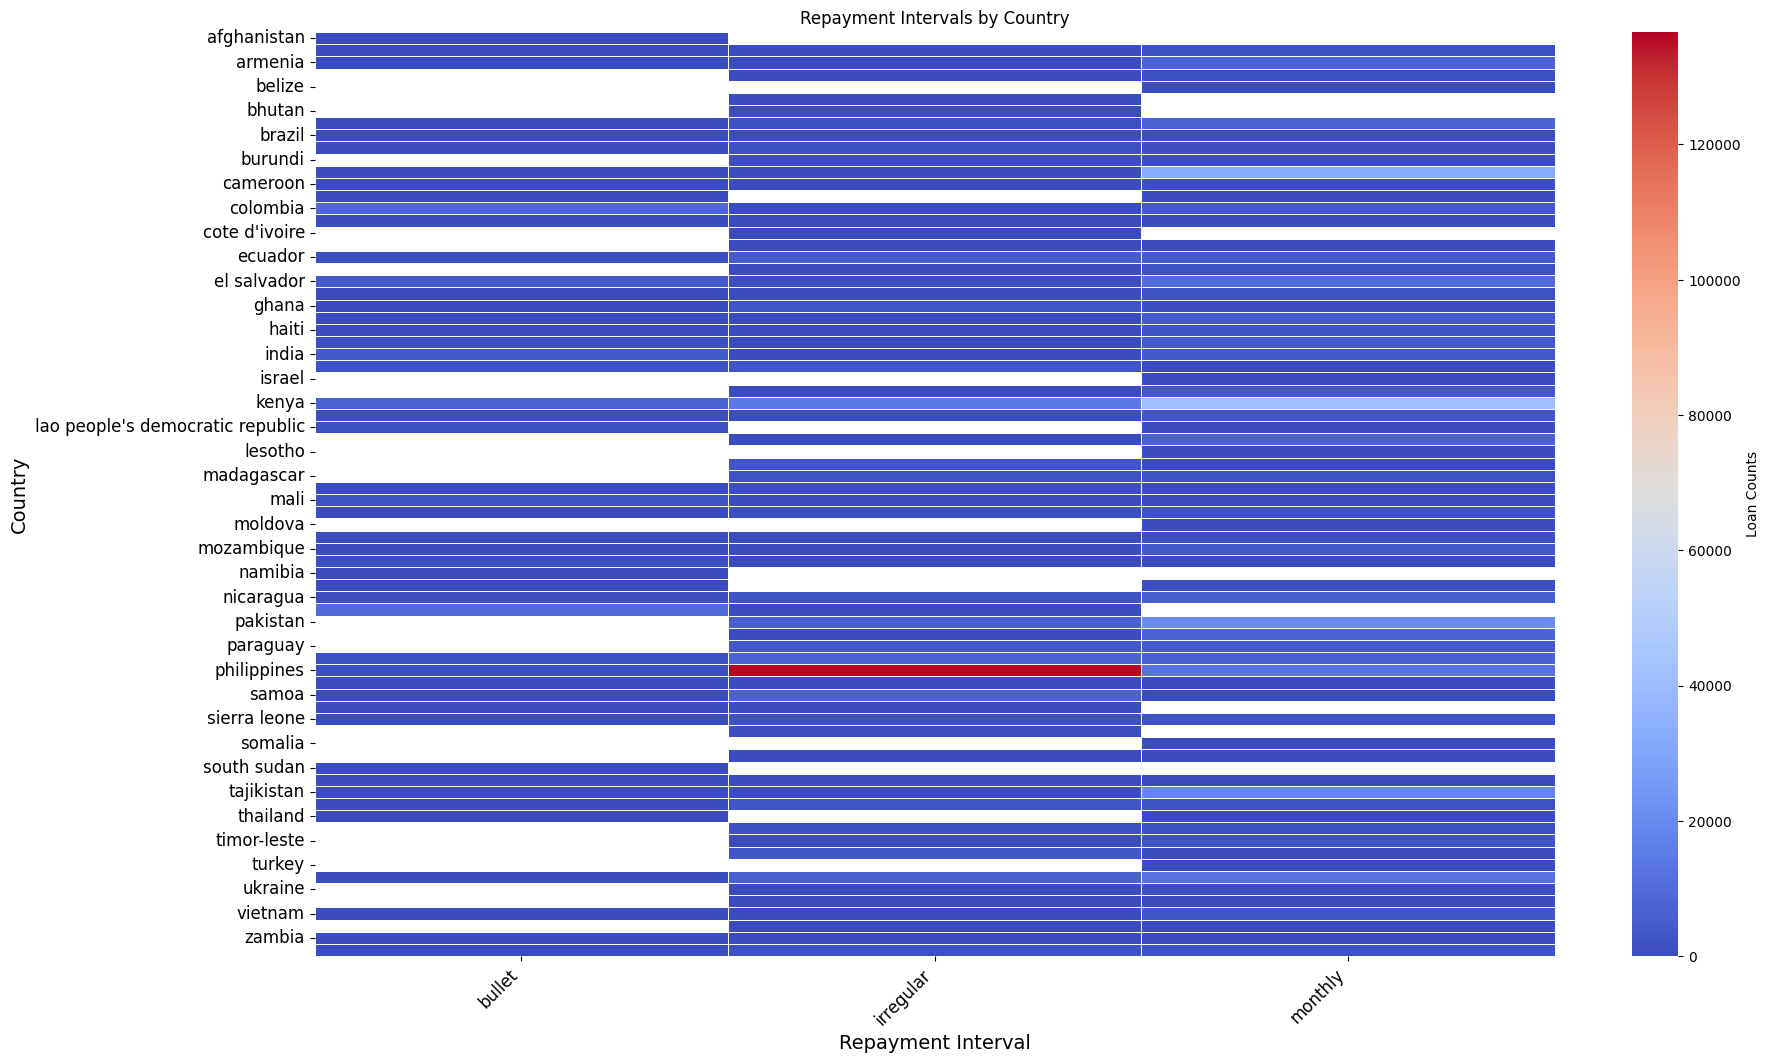

In [197]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting the heatmap with a better color palette
plt.figure(figsize=(20, 12))
sns.heatmap(repayment_heatmap_data, cmap="coolwarm", linewidths=.5, cbar_kws={'label': 'Loan Counts'}, vmin=0, vmax=repayment_heatmap_data.max().max())
plt.title('Repayment Intervals by Country')
plt.xticks(rotation=45, ha='right', fontsize=12)
plt.yticks(rotation=0, fontsize=12)
plt.xlabel('Repayment Interval', fontsize=14)
plt.ylabel('Country', fontsize=14)
plt.show()



The noticeable red line for the Philippines in the ‘irregular’ repayment category shows that many borrowers there follow flexible repayment schedules. This may suggest that Filipino borrowers often have varying incomes or unique financial needs, making irregular loan repayments more suitable for them. Flexible loan terms are likely better suited to the local economic conditions.

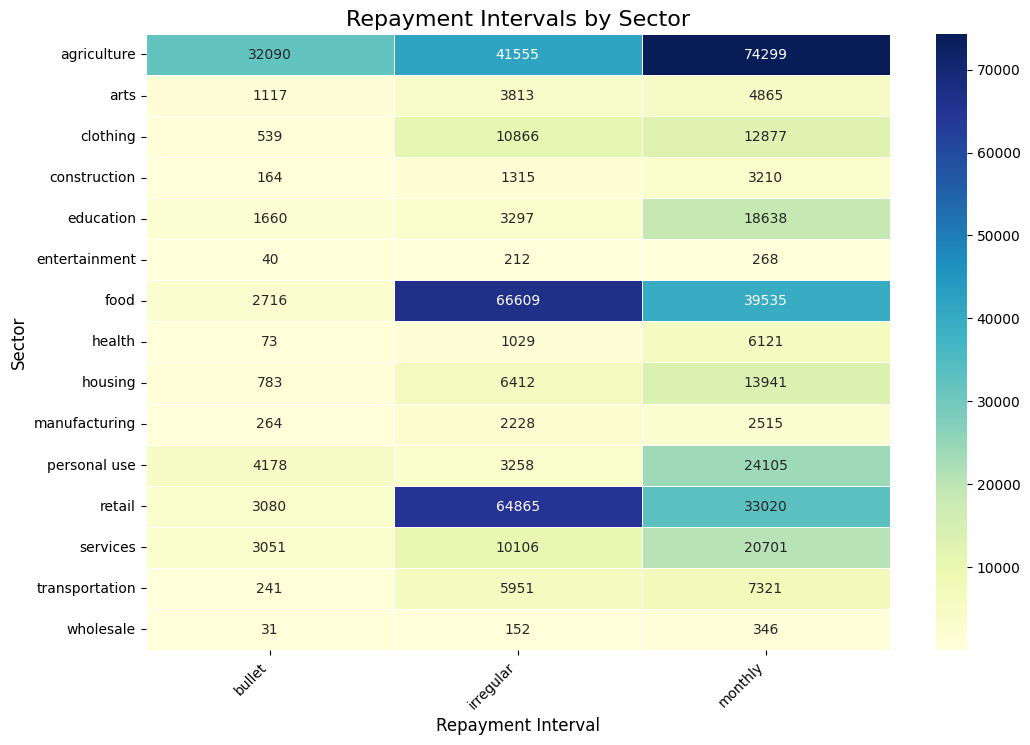

In [198]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by sector and repayment interval to calculate loan counts
repayment_by_sector = df_cleaned.groupby(['sector_x', 'repayment_interval'])['id'].count().reset_index()

# Pivot the data for the heatmap
heatmap_data_sector = repayment_by_sector.pivot_table(index='sector_x', columns='repayment_interval', values='id', fill_value=0)

# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data_sector, annot=True, fmt=".0f", cmap="YlGnBu", linewidths=.5)
plt.title('Repayment Intervals by Sector', fontsize=16)
plt.xlabel('Repayment Interval', fontsize=12)
plt.ylabel('Sector', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.show()


The repayment intervals across sectors and countries reveal a few distinct patterns. Sectors such as agriculture, food, retail, education, personal use and services have the highest concentration of loans, and these sectors tend to favor monthly repayment intervals. The irregular repayment schedule is prominent in food and retail sectors. Bullet repayments are mostly concentrated in agriculture but are also seen across multiple sectors in smaller amounts.

<ipython-input-211-07a94abcdf4d>:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='repayment_interval', data=df_cleaned, palette='Set2')


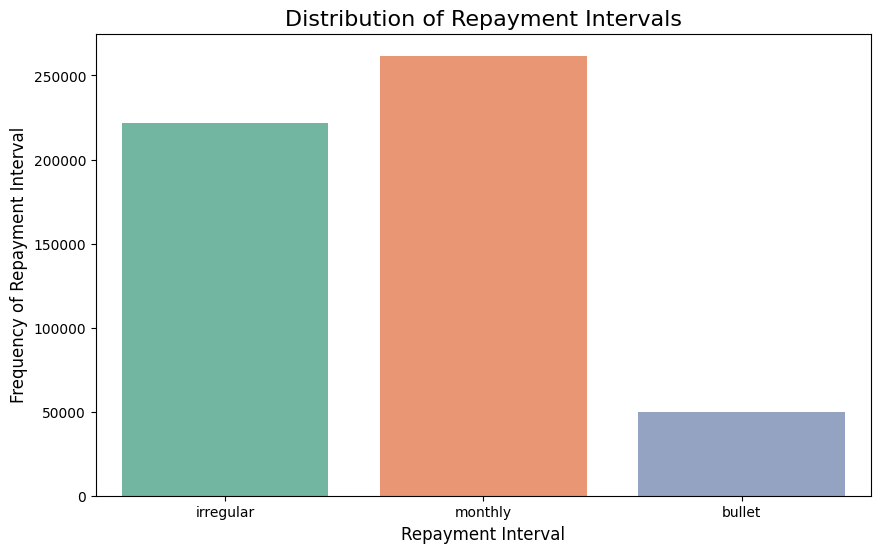

In [211]:
import seaborn as sns
import matplotlib.pyplot as plt

# Create a bar plot to visualize the distribution of repayment intervals
plt.figure(figsize=(10, 6))
sns.countplot(x='repayment_interval', data=df_cleaned, palette='Set2')

# Customize the plot
plt.title('Distribution of Repayment Intervals', fontsize=16)
plt.xlabel('Repayment Interval', fontsize=12)
plt.ylabel('Frequency of Repayment Interval', fontsize=12)

# Show the plot
plt.show()




<ipython-input-203-b6e4db560877>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Loan_Count', y='Activity', data=sector_data, ax=ax, palette='Set2')
<ipython-input-203-b6e4db560877>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Loan_Count', y='Activity', data=sector_data, ax=ax, palette='Set2')
<ipython-input-203-b6e4db560877>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Loan_Count', y='Activity', data=sector_data, ax=ax, palette='Set2')
<ipython-input-203-b6e4db560877>:29: FutureWarning: 

Passing `palette` without assig

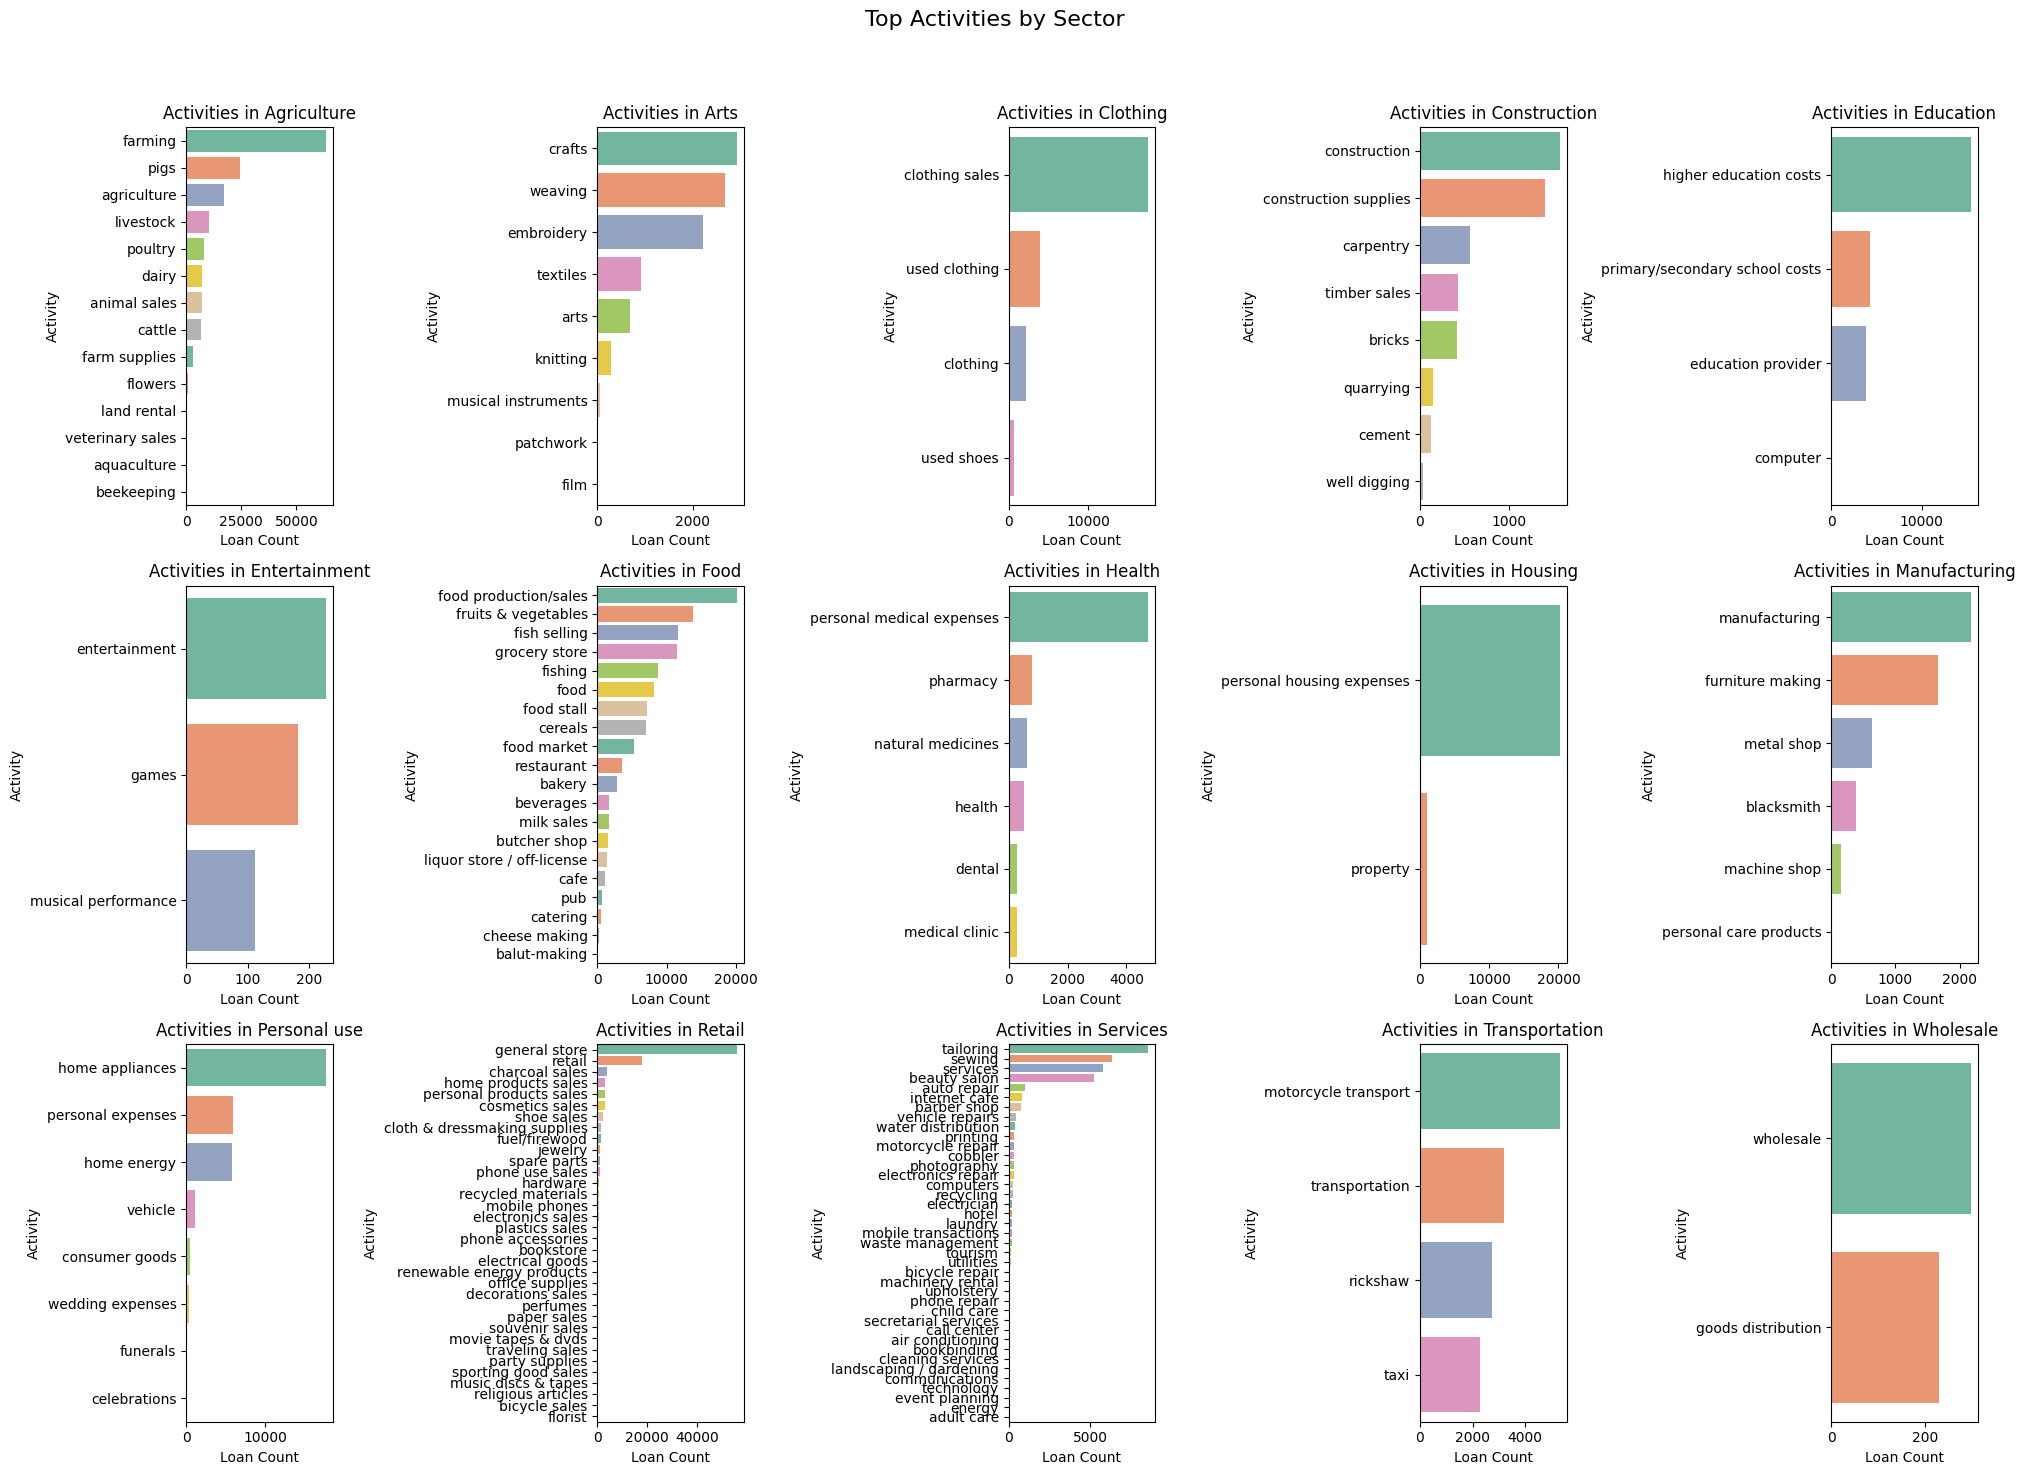

In [203]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group by sector and activity, and count the number of loans for each
activity_counts_by_sector = df_cleaned.groupby(['sector_x', 'activity'])['id'].count().reset_index()

# Rename columns for clarity
activity_counts_by_sector.columns = ['Sector', 'Activity', 'Loan_Count']

# Get unique sectors to create subplots for each sector
unique_sectors = activity_counts_by_sector['Sector'].unique()

# Set up the grid for 15 plots (3 rows by 5 columns)
fig, axes = plt.subplots(3, 5, figsize=(20, 15))
fig.suptitle('Top Activities by Sector', fontsize=16)

# Plot each sector in the grid
for i, sector in enumerate(unique_sectors):
    # Select the data for this specific sector
    sector_data = activity_counts_by_sector[activity_counts_by_sector['Sector'] == sector]

    # Sort by the count of loans
    sector_data = sector_data.sort_values(by='Loan_Count', ascending=False)

    # Get the axis for the subplot
    ax = axes[i // 5, i % 5]

    # Plot the barplot
    sns.barplot(x='Loan_Count', y='Activity', data=sector_data, ax=ax, palette='Set2')
    ax.set_title(f'Activities in {sector.capitalize()}')
    ax.set_xlabel('Loan Count')
    ax.set_ylabel('Activity')

# Adjust layout to avoid overlap
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()




 In agriculture, farming is by far the most prominent activity, followed by pig and general agriculture-related activities. In contrast, sectors like construction and clothing show more diversified activities but with smaller loan counts compared to agriculture.

 Retail stands out with general stores receiving the largest number of loans, showcasing its central role in many communities. The food sector has a wide array of activities, including fish selling, food production, and grocery store-related work, reflecting the importance of food-related businesses in loan applications.

 In personal use, home appliances dominate, indicating the prevalence of household-related expenses. Similarly, sectors like health, entertainment, and manufacturing have fewer activities, suggesting more specialized needs and fewer borrowers compared to agriculture or retail.

 Overall, these patterns indicate that agriculture, retail, and food dominate loan activity, while sectors like arts, entertainment, and transportation are smaller in scope but still vital for certain communities.

<ipython-input-221-65f9646fa729>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='term_in_months', y='sector_x', data=avg_loan_term_sector, palette="Blues_d")


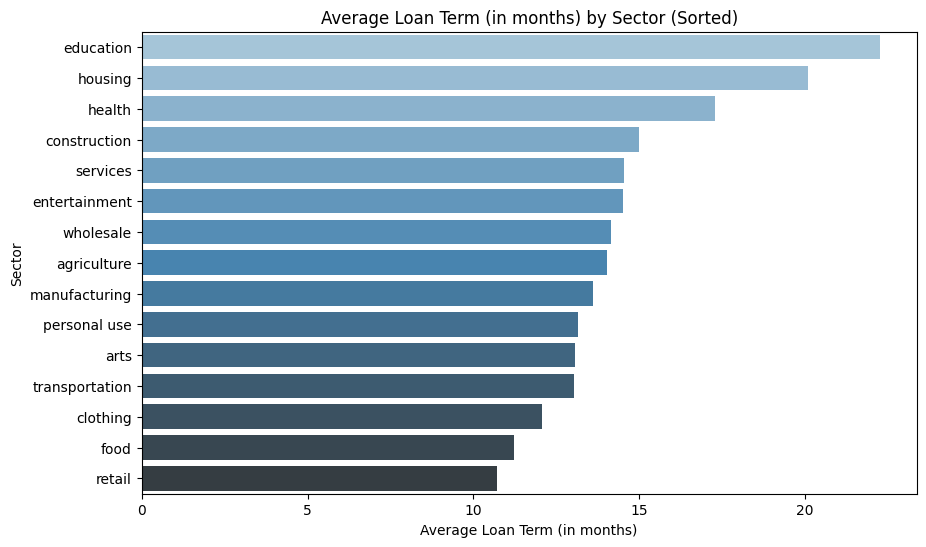

In [221]:
import seaborn as sns
import matplotlib.pyplot as plt

# Group by sector to calculate the average loan term and sort by term_in_months in descending order
avg_loan_term_sector = df_cleaned.groupby('sector_x')['term_in_months'].mean().reset_index()
avg_loan_term_sector = avg_loan_term_sector.sort_values(by='term_in_months', ascending=False)

# Plotting the bar chart for Loan Term by Sector (sorted)
plt.figure(figsize=(10, 6))
sns.barplot(x='term_in_months', y='sector_x', data=avg_loan_term_sector, palette="Blues_d")
plt.title('Average Loan Term (in months) by Sector (Sorted)')
plt.xlabel('Average Loan Term (in months)')
plt.ylabel('Sector')
plt.show()




The bar chart shows that the sectors with the longest average loan terms are education, housing, and health, each with an average loan term exceeding 15 months. These sectors likely require longer loan durations due to the nature of investments in education and housing, which tend to involve larger amounts and longer repayment periods. On the other hand, sectors like retail and food have significantly shorter loan terms, indicating a quicker turnover of loans in those industries, possibly reflecting the need for short-term capital in day-to-day business operations.